# H-SAF Snow Cluster Lab Content

Within the content of this lab session information about snow products those are being
produced by the snow cluster of H-SAF is presented. It is aimed to make the users familiar with the
products and how to make use of the products in their studies easily. This lab session will provide
users a quick reference guide and easy to follow instructions on the snow products. This reference will guide you though 3 steps including:

- ### Module 1
Connect to FTP and retrive data

- ### Module 2
Read downloaded data and visualize
- ### Module 3
Data Projection and Spatial Analysis

<h3 style="color:blue">Snow Products</h3>

The snow products those are being produced by HSAF Snow cluster are as follows, each product
is categorized by the following titles
- H10 – SN-OBS-1
- H11 – SN-OBS-2
- H12 – SN-OBS-3
- H13 – SN-OBS-4

<img src="./image/HSAF.JPG" style="height:500px">

In this session, "H10" and "H34" producs will be used.


### Module 1
-----------------
Snow products are being stored in a File Transfer Protocol (FTP) server and each product has the
following structure to store the archive data. Raw data is stored as “*.grib2” and “*.H5”. In order to download the data Following code connects to FTP and download snow product for a specified date.


In [14]:
import ipywidgets as widgets
from IPython.display import display
widgets.Dropdown(
    options=['H10', 'H13', 'H34'],
    value='H10',
    description='Product:',
    disabled=False,
)

In [3]:
widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)

In [1]:
import glob
import os 
from ftplib import FTP

ftp = FTP('ftphsaf.meteoam.it')
ftp.login("cagrkaraman@gmail.com", "1549682Qs")

product = 'h13'
# date = '20190115'
date = '20190213'
extension = '.grib2.gz'

# for i in glob.glob1(os.getcwd(), "*"+date+".H5"):
#     print(i)

wdir =product + '/h13_cur_mon_data'
ftp.cwd(wdir)
filename = product + '_' + date + '_day_merged' + extension


def grabFile(file_):
    localfile = open(file_, 'wb')
    ftp.retrbinary('RETR ' + file_, localfile.write, 1024)
    localfile.close()
    print("File Downloaded")
    

grabFile(filename)
os.system('gunzip %s' %(filename))

File Downloaded


0

## Module 2
-----------------

Downloaded product can be read through h5py viewer. Visualization of data based on then bands can be achieved.

import necessary libraries

In [2]:
import os
import glob
#import pandas as pd
from pygrib import *
from osgeo import gdal, ogr,gdal_array
from osgeo.gdalconst import *
import numpy as np
import sys
import matplotlib.pyplot as plt
import gdal


In [1]:
os.chdir(r"/home/takalam/h13_training")
files = glob.glob('./*.grib2')
print(files)

NameError: name 'os' is not defined

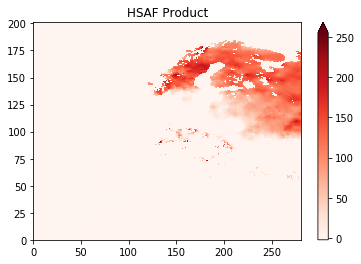

In [10]:
import pygrib

grbs=pygrib.open('h13_20190213_day_merged.grib2')
grb=grbs.select(name='Remotely sensed snow cover')[0]
data=np.flip(grb.values,0)

fig, ax = plt.subplots()
ax.set_title('HSAF Product')
pcm = ax.pcolormesh(data,cmap=plt.cm.Reds)
fig.colorbar(pcm, ax=ax, extend='max')
plt.show()

In [31]:
input_polygon = "Karasu.shp"

In [33]:
def bbox_to_pixel_offsets(gt, bbox):
    originX = gt[0]
    originY = gt[3]
    pixel_width = gt[1]
    pixel_height = gt[5]
    x1 = int((bbox[0] - originX) / pixel_width)
    x2 = int((bbox[1] - originX) / pixel_width) + 1

    y1 = int((bbox[3] - originY) / pixel_height)
    y2 = int((bbox[2] - originY) / pixel_height) + 1

    xsize = x2 - x1
    ysize = y2 - y1
    return (x1, y1, xsize, ysize)

In [52]:
def zonal_stats(vector_path, raster_path, nodata_value=None, global_src_extent=False):
    rds = gdal.Open(raster_path, GA_ReadOnly)
    assert (rds)
    rb = rds.GetRasterBand(1)
    rgt = rds.GetGeoTransform()

    if nodata_value:
        nodata_value = float(nodata_value)
        rb.SetNoDataValue(nodata_value)

    vds = ogr.Open(vector_path, GA_ReadOnly)
    assert (vds)
    vlyr = vds.GetLayer(0)

    if global_src_extent:
        src_offset = bbox_to_pixel_offsets(rgt, vlyr.GetExtent())
        src_array = rb.ReadAsArray(*src_offset)

        # calculate new geotransform of the layer subset
        new_gt = (
            (rgt[0] + (src_offset[0] * rgt[1])),
            rgt[1],
            0.0,
            (rgt[3] + (src_offset[1] * rgt[5])),
            0.0,
            rgt[5]
        )

    mem_drv = ogr.GetDriverByName('Memory')
    driver = gdal.GetDriverByName('MEM')

    # Loop through vectors
    stats = []
    feat = vlyr.GetNextFeature()
    while feat is not None:

        if not global_src_extent:
            src_offset = bbox_to_pixel_offsets(rgt, feat.geometry().GetEnvelope())
            src_array = rb.ReadAsArray(*src_offset)

            # calculate new geotransform of the feature subset
            new_gt = (
                (rgt[0] + (src_offset[0] * rgt[1])),
                rgt[1],
                0.0,
                (rgt[3] + (src_offset[1] * rgt[5])),
                0.0,
                rgt[5]
            )

        # Create a temporary vector layer in memory
        mem_ds = mem_drv.CreateDataSource('out')
        mem_layer = mem_ds.CreateLayer('poly', None, ogr.wkbPolygon)
        mem_layer.CreateFeature(feat.Clone())

        # Rasterize it
        rvds = driver.Create('', src_offset[2], src_offset[3], 1, gdal.GDT_Byte)
        rvds.SetGeoTransform(new_gt)
        gdal.RasterizeLayer(rvds, [1], mem_layer, burn_values=[1])
        rv_array = rvds.ReadAsArray()

        masked = np.ma.MaskedArray(
            src_array,
            mask=np.logical_or(
                src_array == nodata_value,
                np.logical_not(rv_array)
            )
        )

        feature_stats = {
            'min': float(masked.min()),
            'mean': float(masked.mean()),
            'max': float(masked.max()),
            'std': float(masked.std()),
            'sum': float(masked.sum()),
            'count': int(masked.count()),
            'fid': int(feat.GetFID())}

        stats.append(feature_stats)

        rvds = None
        mem_ds = None
        feat = vlyr.GetNextFeature()

    vds = None
    rds = None
    return stats

In [53]:
ZoneID = list('12345')
df = pd.DataFrame(columns=['Date','ZoneID','mean','sum','count'])

In [54]:
for file in files:
    ds = gdal.Open(file)
    b1 = ds.GetRasterBand(1)
    arr = b1.ReadAsArray()
    snow = np.where(arr > 0, 0, 1)
    gdal_array.SaveArray(snow.astype("int8"), 'snow.tif', "GTIFF", ds)
    stats = zonal_stats(input_polygon, 'snow.tif')
    a = pd.DataFrame(stats)
    for i in range(4):
        df = df.append({'Date':str(file[6:14]),'ZoneID': ZoneID[i], 'mean': a['mean'][i], 'sum': a['sum'][i], 'count': a['count'][i]}, ignore_index=True)
    ds = None
    os.remove('snow.tif')

In [55]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [56]:
df.head()

,Date,ZoneID,mean,sum,count
0,2011-06-01,1,0.040816,2.0,49
1,2011-06-01,2,0.013889,2.0,144
2,2011-06-01,3,0.027586,4.0,145
3,2011-06-01,4,0.000000,0.0,83
4,2011-06-05,1,0.224490,11.0,49


In [57]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

w = widgets.Dropdown(
    options=['1', '2','3','4'],
    value='1',
    description='ZoneID:',
    disabled=False,
)

def f(x):
    Zone1 = df.loc[df['ZoneID'] == x]
    ax = Zone1.plot(x='Date',y='mean',kind='line',style='o-',c='red')
    ax.legend(["Zone " +x]);
    ax.set_xlabel('Date')
    ax.set_ylabel('Snow Cover, %')
plt.show()
a = interactive(f,x=w)
display(a)

interactive(children=(Dropdown(description='ZoneID:', options=('1', '2', '3', '4'), value='1'), Output()), _do…

In [58]:
import numpy as np

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file

In [59]:
import numpy as np

from bokeh.layouts import gridplot
from bokeh.plotting import figure, show, output_file,output_notebook
pd.set_option('mode.chained_assignment', None)

w = widgets.Dropdown(
    options=['1', '2','3','4'],
    value='1',
    description='ZoneID:',
    disabled=False,
)

output_notebook()

def f(x):
    Zone1 = df.loc[df['ZoneID'] == x]
    Zone1['Date'] = pd.to_datetime(Zone1['Date'])
    Zone1 = Zone1.sort_values(by='Date')
    TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

    p1 = figure(title="Legend Example", tools=TOOLS,x_axis_type="datetime")
    # p1.legend.title = 'Example Title'
    p1.yaxis.axis_label = 'Snow Cover, %'
    p1.xaxis.axis_label = 'Date'

    p1.line(Zone1['Date'], Zone1['mean']*100, color='navy', alpha=0.5)
    p1.circle(Zone1['Date'], Zone1['mean']*100, fill_color="blue", size=8)
    show(p1)
    

a = interactive(f,x=w)
display(a)

Loading BokehJS ...

interactive(children=(Dropdown(description='ZoneID:', options=('1', '2', '3', '4'), value='1'), Output()), _do…

In [60]:
Zone1 = df.loc[df['ZoneID'] == '1']
Zone1 = Zone1.sort_values(by='Date')
Zone1.head()

,Date,ZoneID,mean,sum,count
0,2011-06-01,1,0.040816,2.0,49
20,2011-06-02,1,0.102041,5.0,49
8,2011-06-03,1,0.081633,4.0,49
16,2011-06-04,1,0.000000,0.0,49
4,2011-06-05,1,0.224490,11.0,49


In [61]:
import numpy as np

from bokeh.io import show
from bokeh.layouts import column
from bokeh.models import ColumnDataSource, RangeTool
from bokeh.plotting import figure

In [62]:
dates = np.array(Zone1['Date'], dtype=np.datetime64)

In [63]:
source = ColumnDataSource(data=dict(date=dates, close=Zone1['mean']))
p = figure(plot_height=150, plot_width=800, tools="xpan", toolbar_location=None,
           x_axis_type="datetime", x_axis_location="above",
           background_fill_color="#efefef", x_range=(dates[2], dates[3]))
p.line('date', 'close', source=source)
p.yaxis.axis_label = 'Snow Cover, %'
select = figure(title="Drag the middle and edges of the selection box to change the range above",
                plot_height=130, plot_width=800, y_range=p.y_range,
                x_axis_type="datetime", y_axis_type=None,
                tools="", toolbar_location=None, background_fill_color="#efefef")

In [64]:
range_tool = RangeTool(x_range=p.x_range)
range_tool.overlay.fill_color = "navy"
range_tool.overlay.fill_alpha = 0.2

select.line('date', 'close', source=source)
select.ygrid.grid_line_color = None
select.add_tools(range_tool)
select.toolbar.active_multi = range_tool

show(column(p, select))